In [1]:
import pytest
import torch

In [2]:
import sys
sys.path.insert(0, '../tests/')

In [3]:
from conftest import *
from pathlib import Path

paths = dict(data = Path('../data/'))

device = 'cuda:0'

use_cuda = True

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%matplotlib inline

# Set up models

In [ ]:
slen = 50
tile_slen = slen

In [ ]:
decoder_setup = DecoderSetup(paths, device)

In [8]:
use_cuda = True

n_epochs = 100 if use_cuda else 1

# simulates either 1 or 2 galaxies in a 50 x 50 image
# the input to the encoder is the 50 x 50 image
slen = 50
tile_slen = slen

In [9]:
galaxy_dataset = decoder_setup.get_galaxy_dataset(
            slen=slen,
            tile_slen=tile_slen,
            batch_size=64 if use_cuda else 2,
            n_images=640 if use_cuda else 2,
            max_sources_per_tile=2,
            min_sources_per_tile=1,
            # this is so that prob(n_source = 1) \approx prob(n_source = 2) \approx = 0.5
            # under the poisson prior
            mean_sources_per_tile=1.67
        )

In [10]:
params = galaxy_dataset.get_batch()

In [11]:
(params['n_sources'] == 1).float().mean()

tensor(0.3281, device='cuda:0')

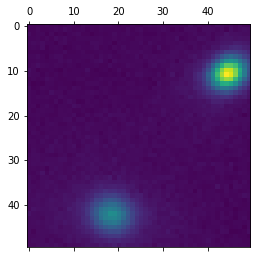

In [12]:
plt.matshow(params['images'].detach().cpu()[0, 0])

# Train

In [13]:
encoder_setup = EncoderSetup(gpus = 1, device = device)

In [14]:
trained_encoder = encoder_setup.get_trained_encoder(
    galaxy_dataset,
    n_epochs=n_epochs,
    max_detections=2,
    ptile_slen=tile_slen,
    tile_slen=tile_slen,
    validation_plot_start=0,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | image_encoder | ImageEncoder | 814 K 
/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1: : 10it [00:02,  3.93it/s, loss=4.502]
Validating: 0it [00:00, ?it/s]
Epoch 1: : 13it [00:02,  4.90it/s, loss=4.502]
Epoch 1: : 16it [00:02,  5.79it/s, loss=4.502]
Epoch 1: : 20it [00:03,  5.97it/s, loss=4.502]
Epoch 2: : 10it [00:02,  3.97it/s, loss=3.966]
Epoch 2: : 12it [00:02,  4.64it/s, loss=3.966]
Epoch 2: : 16it [00:02,  5.91it/s, loss=3.966]
Epoch 2: : 20it [00:03,  5.92it/s, loss=3.966]
Epoch 3: : 10it [00:02,  3.99it/s, loss=2.990]
Epoch 3: : 12it [00:02,  4.67it/s, loss=2.990]
Epoch 3: : 16it [00:02,  5.94it/s, loss=2.990]
Epoch 3: : 20it [00:03,  6.05it/s, loss=2.990]
Epoch 4: : 10it [00:02,  3.98it/s, loss=2.199]
Epoch 4: : 12it [00:02,  4.65it/s, loss=2.199]
Validating: 3it [00:00, 29.19it/s]
Epoch 4: : 16it [00:02,  5.88it/s, loss=2.199]
Epoch 4: : 20it [00:03,  6.00it/s, loss=2.199]
Epoch 5: : 10it [00:02,  3.99it/s, loss=1.464]
Epoch 5: : 12it [00:02,  4.67it/s, loss=1.464]
Epoch 5: : 16it [00:02,  5.94it/s, loss=1.464]
Epoch 5: : 20it [00:03,  5.90it/s, loss=1

# Evaluate

### Evaluate on saved test image

In [15]:
test_galaxy = torch.load('../data/2_galaxy_test.pt')
test_image = test_galaxy['images']

In [24]:
with torch.no_grad():
    # get the estimated params
    trained_encoder.eval()
    (
        n_sources,
        locs,
        galaxy_params,
        log_fluxes,
        galaxy_bool,
    ) = trained_encoder.map_estimate(test_image.to(device))
    
    locs = locs.squeeze(1)

In [25]:
%matplotlib inline  

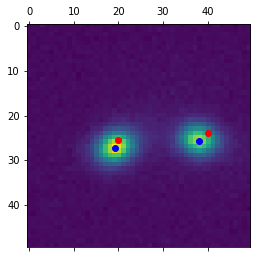

In [26]:
plt.matshow(test_image[0, 0])
plt.scatter(test_galaxy['locs'][0, :, 1] * slen - 0.5, 
            test_galaxy['locs'][0, :, 0] * slen - 0.5, color = 'blue')

plt.scatter(locs.detach().cpu()[0, :, 1] * slen - 0.5, 
            locs.detach().cpu()[0, :, 0] * slen - 0.5, color = 'red')

In [27]:
locs

tensor([[[0.4880, 0.8101],
         [0.5184, 0.4067]]], device='cuda:0')

In [30]:
test_galaxy["locs"]

tensor([[[0.5220, 0.7711],
         [0.5550, 0.3933]]])

In [28]:
diff_locs = test_galaxy["locs"].sort(1)[0].to(device) - locs.sort(1)[0]
diff_locs *= test_image.size(-1)

In [29]:
diff_locs

tensor([[[ 1.7038, -0.6686],
         [ 1.8306, -1.9510]]], device='cuda:0')

### Evalute on data from data-loader